# 作業

In [1]:
from sklearn import datasets, metrics, preprocessing
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, Imputer, StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [21]:
#讀入資料
data_path = 'data/'
trainDf = pd.read_csv(data_path + 'train_data_MarathonByCupoy.csv')
testDf = pd.read_csv(data_path + 'test_features_MarathonByCupoy.csv')
trainLabel = trainDf['poi']
#從資料數值來看，有著許多遺漏值，特別是load_advances 僅有兩筆資料，後續將進行資料補值
#從資料屬性來看，共有2個類別變數，其餘為連續變數
trainDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 22 columns):
name                         113 non-null object
bonus                        61 non-null float64
deferral_payments            28 non-null float64
deferred_income              34 non-null float64
director_fees                13 non-null float64
email_address                83 non-null object
exercised_stock_options      81 non-null float64
expenses                     73 non-null float64
from_messages                65 non-null float64
from_poi_to_this_person      65 non-null float64
from_this_person_to_poi      65 non-null float64
loan_advances                2 non-null float64
long_term_incentive          49 non-null float64
other                        69 non-null float64
poi                          113 non-null bool
restricted_stock             82 non-null float64
restricted_stock_deferred    10 non-null float64
salary                       73 non-null float64
shared_receipt_wi

In [22]:
#從數據描述上來看，需要進行單位標準化，排除不同單位對模型造成的影響
trainDf.describe()

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
count,6.100000e+01,2.800000e+01,3.400000e+01,13.000000,8.100000e+01,73.000000,65.000000,65.000000,65.000000,2.000000e+00,4.900000e+01,6.900000e+01,8.200000e+01,10.000000,7.300000e+01,65.000000,65.000000,9.600000e+01,9.800000e+01
mean,1.147436e+06,6.344374e+05,-4.625664e+05,89397.846154,2.985081e+06,51040.547945,711.323077,64.800000,40.092308,4.096250e+07,7.926171e+05,4.471774e+05,1.294855e+06,-221885.700000,2.739025e+05,1111.369231,2156.061538,2.590977e+06,3.527136e+06
std,1.505189e+06,8.603646e+05,8.095392e+05,41143.391399,6.004174e+06,47596.682104,2074.497628,91.863214,88.901407,5.736404e+07,9.504645e+05,1.341564e+06,2.498335e+06,205191.374121,1.716647e+05,1165.852016,2811.676718,1.056645e+07,7.182997e+06
min,7.000000e+04,-1.025000e+05,-3.504386e+06,3285.000000,3.285000e+03,148.000000,12.000000,0.000000,0.000000,4.000000e+05,7.102300e+04,2.000000e+00,4.409300e+04,-560222.000000,4.770000e+02,2.000000,57.000000,1.480000e+02,-4.409300e+04
25%,4.500000e+05,7.656750e+04,-5.527032e+05,101250.000000,4.004780e+05,18834.000000,19.000000,10.000000,0.000000,2.068125e+07,2.750000e+05,9.720000e+02,2.689220e+05,-389621.750000,2.061210e+05,178.000000,517.000000,3.024025e+05,4.211518e+05
50%,7.500000e+05,1.951900e+05,-1.175340e+05,108579.000000,8.500100e+05,41953.000000,45.000000,28.000000,7.000000,4.096250e+07,4.221580e+05,5.238200e+04,4.628225e+05,-139856.500000,2.516540e+05,599.000000,1088.000000,1.106740e+06,9.979710e+05
75%,1.000000e+06,8.342052e+05,-2.708325e+04,112492.000000,2.165172e+06,59175.000000,215.000000,88.000000,27.000000,6.124375e+07,8.318090e+05,3.620960e+05,9.664905e+05,-77953.250000,2.885890e+05,1902.000000,2649.000000,1.985668e+06,2.493616e+06
max,8.000000e+06,2.964506e+06,-1.042000e+03,125034.000000,3.434838e+07,228763.000000,14368.000000,528.000000,411.000000,8.152500e+07,5.145434e+06,1.035973e+07,1.476169e+07,44093.000000,1.111258e+06,4527.000000,15149.000000,1.035598e+08,4.911008e+07


In [23]:
#將訓練資料:email數值化分成有(1)和沒有(0)
email_address_temp=trainDf['email_address']
for i in range(len(trainDf)):
    if email_address_temp[i]=='NAN':
        email_address_temp[i]=0
    else:
        email_address_temp[i]=1
trainDf['email_address']=email_address_temp
trainDf.head()

C:\Users\JL\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,name,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,RICE KENNETH D,1750000.0,NaN,-3504386.0,NaN,1,19794175.0,46950.0,18.0,42.0,...,1617011.0,174839.0,True,2748364.0,NaN,420636.0,864.0,905.0,505050.0,22542539.0
1,SKILLING JEFFREY K,5600000.0,NaN,NaN,NaN,1,19250000.0,29336.0,108.0,88.0,...,1920000.0,22122.0,True,6843672.0,NaN,1111258.0,2042.0,3627.0,8682716.0,26093672.0
2,SHELBY REX,200000.0,NaN,-4167.0,NaN,1,1624396.0,22884.0,39.0,13.0,...,NaN,1573324.0,True,869220.0,NaN,211844.0,91.0,225.0,2003885.0,2493616.0
3,KOPPER MICHAEL J,800000.0,NaN,NaN,NaN,1,NaN,118134.0,NaN,NaN,...,602671.0,907502.0,True,985032.0,NaN,224305.0,NaN,NaN,2652612.0,985032.0
4,CALGER CHRISTOPHER F,1250000.0,NaN,-262500.0,NaN,1,NaN,35818.0,144.0,199.0,...,375304.0,486.0,True,126027.0,NaN,240189.0,2188.0,2598.0,1639297.0,126027.0


In [24]:
#將測試資料:email數值化分成有(1)和沒有(0)
email_address_temp=testDf['email_address']
for i in range(len(testDf)):
    if email_address_temp[i]=='NAN':
        email_address_temp[i]=0
    else:
        email_address_temp[i]=1
testDf['email_address']=email_address_temp
testDf.head()

C:\Users\JL\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,name,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,...,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,BELDEN TIMOTHY N,5249999.0,2144013.0,-2334434.0,NaN,1,953136.0,17355.0,484.0,228.0,...,NaN,NaN,210698.0,157569.0,NaN,213999.0,5521.0,7991.0,5501630.0,1110705.0
1,BOWEN JR RAYMOND M,1350000.0,NaN,-833.0,NaN,1,NaN,65907.0,27.0,140.0,...,NaN,974293.0,1621.0,252055.0,NaN,278601.0,1593.0,1858.0,2669589.0,252055.0
2,HANNON KEVIN P,1500000.0,NaN,-3117011.0,NaN,1,5538001.0,34039.0,32.0,32.0,...,NaN,1617011.0,11350.0,853064.0,NaN,243293.0,1035.0,1045.0,288682.0,6391065.0
3,DELAINEY DAVID W,3000000.0,NaN,NaN,NaN,1,2291113.0,86174.0,3069.0,66.0,...,NaN,1294981.0,1661.0,1323148.0,NaN,365163.0,2097.0,3093.0,4747979.0,3614261.0
4,CAUSEY RICHARD A,1000000.0,NaN,-235000.0,NaN,1,NaN,30674.0,49.0,58.0,...,NaN,350000.0,307895.0,2502063.0,NaN,415189.0,1585.0,1892.0,1868758.0,2502063.0


Numbers of remain columns 19


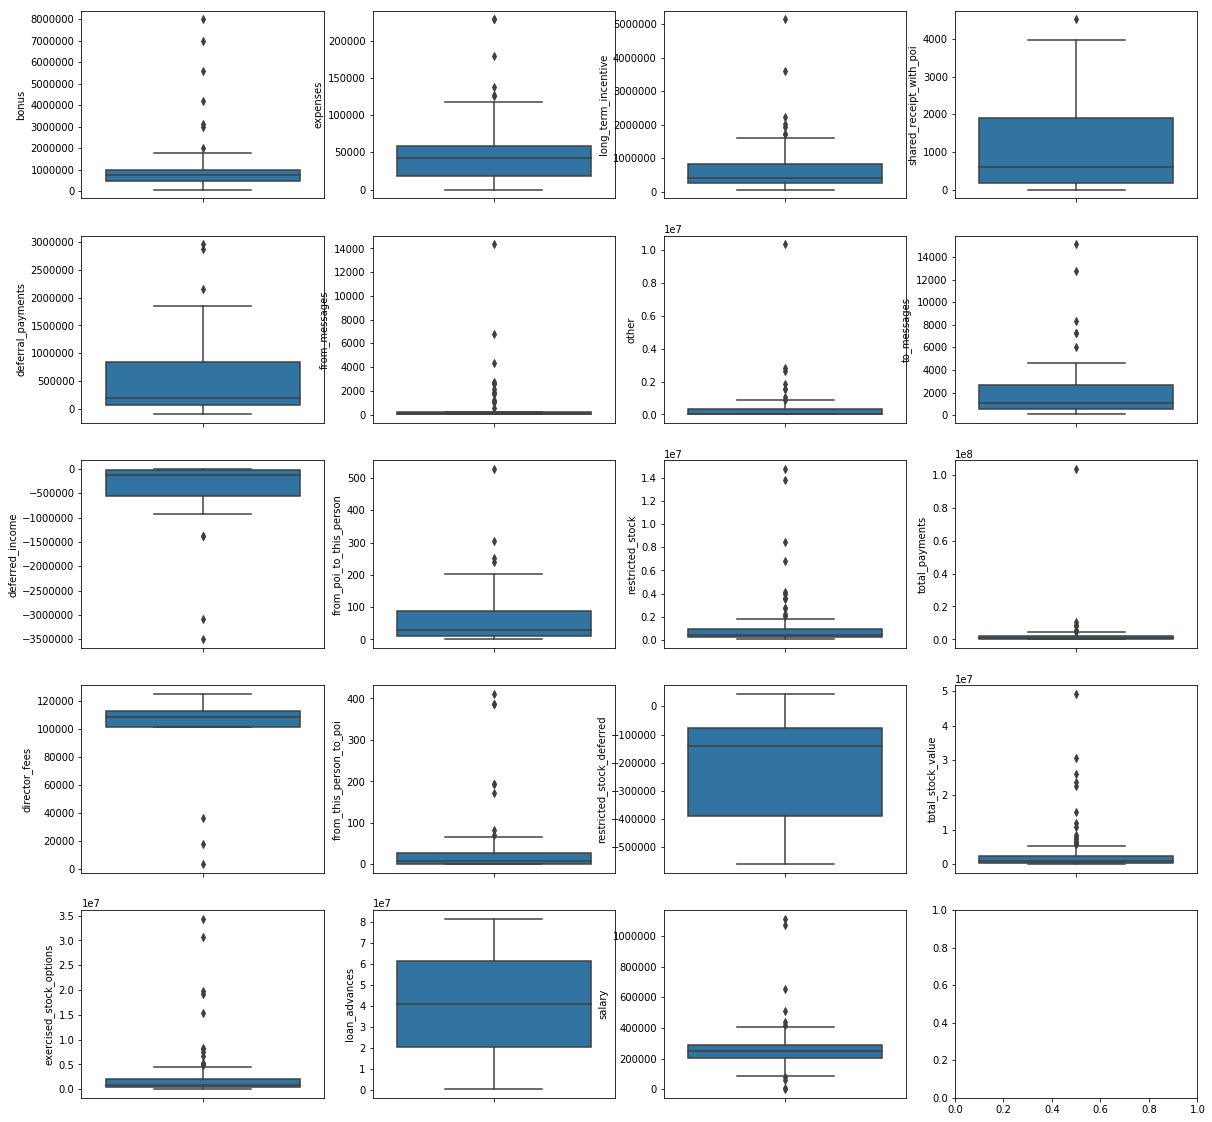

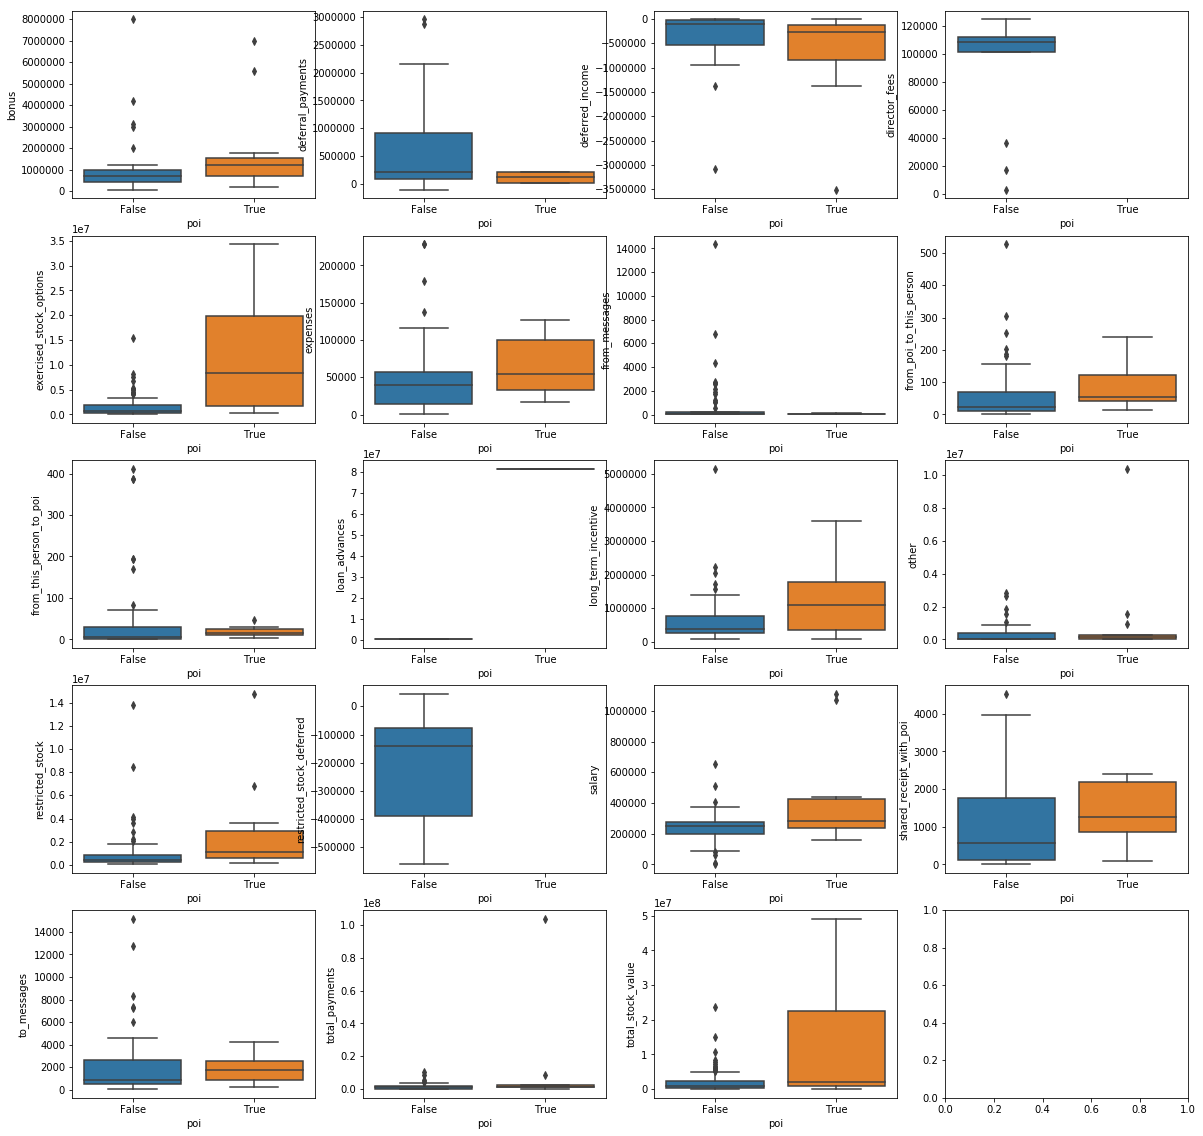

In [25]:
# 先篩選數值型的欄位
numeric_columns = list(trainDf.columns[list(trainDf.dtypes.isin(['int64', 'float64']))])

# 再把只有 2 值 (通常是 0,1) 的欄位去掉
numeric_columns = list(trainDf[numeric_columns].columns[list(trainDf[numeric_columns].apply(lambda x:len(x.unique())!=2 ))])
print("Numbers of remain columns %s" % len(numeric_columns))

#檢視這些欄位的分別對應的boxplot
f1,ax1 = plt.subplots(5,4,figsize=(20,20))
k=0
for i in range(4):
    for j in range(5):
        if i==3 and j==4:
            None
        else:
            sns.boxplot(y=numeric_columns[k],data=trainDf,ax=ax1[j,i])
            k=k+1
        
# 檢視這些欄位的分別對應poi的boxplot
f2,ax2 = plt.subplots(5,4,figsize=(20,20))
sns.boxplot(x='poi',y=numeric_columns[0],data=trainDf,ax=ax2[0,0])
sns.boxplot(x='poi',y=numeric_columns[1],data=trainDf,ax=ax2[0,1])
sns.boxplot(x='poi',y=numeric_columns[2],data=trainDf,ax=ax2[0,2])
sns.boxplot(x='poi',y=numeric_columns[3],data=trainDf,ax=ax2[0,3])
sns.boxplot(x='poi',y=numeric_columns[4],data=trainDf,ax=ax2[1,0])
sns.boxplot(x='poi',y=numeric_columns[5],data=trainDf,ax=ax2[1,1])
sns.boxplot(x='poi',y=numeric_columns[6],data=trainDf,ax=ax2[1,2])
sns.boxplot(x='poi',y=numeric_columns[7],data=trainDf,ax=ax2[1,3])
sns.boxplot(x='poi',y=numeric_columns[8],data=trainDf,ax=ax2[2,0])
sns.boxplot(x='poi',y=numeric_columns[9],data=trainDf,ax=ax2[2,1])
sns.boxplot(x='poi',y=numeric_columns[10],data=trainDf,ax=ax2[2,2])
sns.boxplot(x='poi',y=numeric_columns[11],data=trainDf,ax=ax2[2,3])
sns.boxplot(x='poi',y=numeric_columns[12],data=trainDf,ax=ax2[3,0])
sns.boxplot(x='poi',y=numeric_columns[13],data=trainDf,ax=ax2[3,1])
sns.boxplot(x='poi',y=numeric_columns[14],data=trainDf,ax=ax2[3,2])
sns.boxplot(x='poi',y=numeric_columns[15],data=trainDf,ax=ax2[3,3])
sns.boxplot(x='poi',y=numeric_columns[16],data=trainDf,ax=ax2[4,0])
sns.boxplot(x='poi',y=numeric_columns[17],data=trainDf,ax=ax2[4,1])
sns.boxplot(x='poi',y=numeric_columns[18],data=trainDf,ax=ax2[4,2])

In [26]:
#前處理，補值
del trainDf['poi'] #移除label
del trainDf['name'] #移除name
del testDf['name'] #移除nametrainDfGroup

In [49]:
print(trainDf)

         bonus  deferral_payments  deferred_income  director_fees  \
0    1750000.0                NaN       -3504386.0            NaN   
1    5600000.0                NaN              NaN            NaN   
2     200000.0                NaN          -4167.0            NaN   
3     800000.0                NaN              NaN            NaN   
4    1250000.0                NaN        -262500.0            NaN   
5          NaN            10259.0              NaN            NaN   
6          NaN                NaN              NaN            NaN   
7    1200000.0            27610.0        -144062.0            NaN   
8    7000000.0           202911.0        -300000.0            NaN   
9     600000.0                NaN              NaN            NaN   
10    700000.0                NaN              NaN            NaN   
11    700000.0           214678.0        -100000.0            NaN   
12   1300000.0                NaN       -1386055.0            NaN   
13    750000.0                NaN 

In [9]:
#trainDf['bonus'][0:14]=(trainDf['bonus'][0:14]).fillna(((trainDf['bonus'].groupby(trainLabel)).mean())[0])
#trainDf['bonus'][14:114]=(trainDf['bonus'][14:114]).fillna(((trainDf['bonus'].groupby(trainLabel)).mean())[1])
#trainDf['deferral_payments'][0:14]=(trainDf['deferral_payments'][0:14]).fillna(((trainDf['deferral_payments'].groupby(trainLabel)).mean())[0])
#trainDf['deferral_payments'][14:114]=(trainDf['deferral_payments'][14:114]).fillna(((trainDf['deferral_payments'].groupby(trainLabel)).mean())[1])

C:\Users\JL\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\JL\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\JL\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\JL\Anaconda3\lib\si

In [85]:
#trainDf.describe()
col='director_fees'
trainDfGroup=trainDf[col].groupby(trainLabel)
trainDfGroupMean=trainDfGroup.mean()

trainDfGroupMean.values[1]
#type(trainDfGroupMean.values[1]==None)
#print(trainDfGroupMean.values[1])
#print(col)

nan

In [66]:
for col in numeric_columns: #NAN資料依據以其特徵對應poi分群計算平均值補值
    trainDfGroup=trainDf[col].groupby(trainLabel)
    trainDfGroupMean=trainDfGroup.mean()
    if trainDfGroupMean[0]==NaN:
        trainDf[col][0:14]=(trainDf[col][0:14]).fillna(0)
        trainDf[col][14:114]=(trainDf[col][14:114]).fillna(trainDfGroupMean[1])
    elif trainDfGroupMean[1]==NaN:
        trainDf[col][0:14]=(trainDf[col][0:14]).fillna(trainDfGroupMean[0])
        trainDf[col][14:114]=(trainDf[col][14:114]).fillna(0)
    else:
        trainDf[col][0:14]=(trainDf[col][0:14]).fillna(trainDfGroupMean[0])
        trainDf[col][14:114]=(trainDf[col][14:114]).fillna(trainDfGroupMean[1])
trainDf

NameError: name 'NaN' is not defined

In [11]:
len(numeric_columns)

19

In [12]:
#前處理，Normalize values

def normalize_value(trainX,testX):
    testValue = testX.values
    trainValue = trainX.values
    testx = ( testValue - np.mean(trainValue) ) / ( np.std(trainValue) )
    trainx = ( trainValue - np.mean(trainValue) ) / ( np.std(trainValue) )
    return trainx,testx

for col in numeric_columns:
    trainDf[col],testDf[col]=normalize_value(trainDf[col],testDf[col])

trainDf.head()

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,0.287943,0.342319,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.662242,0.342319,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1.070540,0.342319,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.544676,0.342319,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.150277,0.342319,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# 切分訓練集/測試集
x_train, x_test, y_train, y_test = train_test_split(trainDf, trainLabel, test_size=0.25, random_state=4)

# 建立模型
GBC = GradientBoostingClassifier(random_state=7)

# 訓練模型
GBC.fit(x_train, y_train)

# 預測測試集
GBC_y_pred = GBC.predict(x_test)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [19]:
print(x_train)
print(y_train.shape)

        bonus  deferral_payments  deferred_income  director_fees  \
81  -0.719964          -0.819101              NaN            NaN   
29  -0.895252          -0.097250              NaN            NaN   
102 -0.895252          -0.097250              NaN            NaN   
14   2.413313           5.396145              NaN            NaN   
68  -0.237921           3.720904              NaN            NaN   
31  -1.026718          -0.097250              NaN            NaN   
41   0.308556          -0.097250              NaN            NaN   
61   0.308556          -0.097250              NaN            NaN   
4   -0.150277           0.342319              NaN            NaN   
79   0.308556          -0.097250              NaN            NaN   
88  -1.158184          -0.926024              NaN            NaN   
67  -0.632320          -0.097250              NaN            NaN   
96  -0.544676          -0.097250              NaN            NaN   
37   0.308556          -0.097250              Na

In [252]:
GBC_acc = metrics.accuracy_score(y_test, GBC_y_pred)
print("GBC Acuuracy: ", GBC_acc)

GBC Acuuracy:  0.9310344827586207


In [262]:
# 設定要訓練的超參數組合
n_estimators = [100, 500, 1000]
max_depth = [5, 10, 15, 20]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)

## 建立搜尋物件，放入模型及參數組合字典 (n_jobs=-1 會使用全部 cpu 平行運算)
grid_search = GridSearchCV(GBC, param_grid, scoring="accuracy", n_jobs=-1, verbose=1)

# 開始搜尋最佳參數
grid_result = grid_search.fit(x_train, y_train)

# 預設會跑 3-fold cross-validadtion，總共 12 種參數組合，總共要 train 36 次模型

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    5.9s finished


In [263]:
# 印出最佳結果與最佳參數
print("Best Accuracy: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best Accuracy: 0.976190 using {'max_depth': 5, 'n_estimators': 100}


In [264]:
grid_result.best_params_

{'max_depth': 5, 'n_estimators': 100}

In [265]:
# 使用最佳參數重新建立模型
GBC_bestparam = GradientBoostingClassifier(max_depth=grid_result.best_params_['max_depth'],
                                           n_estimators=grid_result.best_params_['n_estimators'])
# 訓練模型
GBC_bestparam.fit(x_train, y_train)

# 預測測試集
y_pred = GBC_bestparam.predict(x_test)

In [269]:
# 調整參數後正確率
print(metrics.accuracy_score(y_test, y_pred))

0.9310344827586207


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,name,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,...,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
1,BELDEN TIMOTHY N,5249999,2144013,-2334434,NaN,tim.belden@enron.com,953136,17355,484,228,...,NaN,NaN,210698,157569,NaN,213999,5521,7991,5501630,1110705
2,BOWEN JR RAYMOND M,1350000,NaN,-833,NaN,raymond.bowen@enron.com,NaN,65907,27,140,...,NaN,974293,1621,252055,NaN,278601,1593,1858,2669589,252055
3,HANNON KEVIN P,1500000,NaN,-3117011,NaN,kevin.hannon@enron.com,5538001,34039,32,32,...,NaN,1617011,11350,853064,NaN,243293,1035,1045,288682,6391065
4,DELAINEY DAVID W,3000000,NaN,NaN,NaN,david.delainey@enron.com,2291113,86174,3069,66,...,NaN,1294981,1661,1323148,NaN,365163,2097,3093,4747979,3614261


In [282]:
#test 資料前處理
#將email數值化分成有(1)和沒有(0)
email_address_temp=testDf['email_address']
for i in range(len(testDf)):
    if email_address_temp[i]=='NAN':
        email_address_temp[i]=0
    else:
        email_address_temp[i]=1
testDf['email_address']=email_address_temp


del testDf['name'] #移除name

testDf.head()


C:\Users\JL\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,5249999.0,2144013.0,-2334434.0,NaN,1,953136.0,17355.0,484.0,228.0,108.0,NaN,NaN,210698.0,157569.0,NaN,213999.0,5521.0,7991.0,5501630.0,1110705.0
1,1350000.0,NaN,-833.0,NaN,1,NaN,65907.0,27.0,140.0,15.0,NaN,974293.0,1621.0,252055.0,NaN,278601.0,1593.0,1858.0,2669589.0,252055.0
2,1500000.0,NaN,-3117011.0,NaN,1,5538001.0,34039.0,32.0,32.0,21.0,NaN,1617011.0,11350.0,853064.0,NaN,243293.0,1035.0,1045.0,288682.0,6391065.0
3,3000000.0,NaN,NaN,NaN,1,2291113.0,86174.0,3069.0,66.0,609.0,NaN,1294981.0,1661.0,1323148.0,NaN,365163.0,2097.0,3093.0,4747979.0,3614261.0
4,1000000.0,NaN,-235000.0,NaN,1,NaN,30674.0,49.0,58.0,12.0,NaN,350000.0,307895.0,2502063.0,NaN,415189.0,1585.0,1892.0,1868758.0,2502063.0


In [ ]:
def normalize_value_test(testX,trainX):
    """
    Your Code Here, compelete this function
    """
    
    testValue = testX.values
    trainValue = trainX.values
    x = ( testValue - np.mean(trainValue) ) / ( np.std(trainValue) )
    return x

for col in numeric_columns:
    testDf[col]=normalize_value_test(testDf[col],trainDf[col])

testDf.head()
#GBC_y_test_pred = GBC.predict(testDf)

In [283]:
trainDf

,name,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,RICE KENNETH D,1750000.0,NaN,-3504386.0,NaN,ken.rice@enron.com,19794175.0,46950.0,18.0,42.0,...,1617011.0,174839.0,True,2748364.0,NaN,420636.0,864.0,905.0,505050.0,22542539.0
1,SKILLING JEFFREY K,5600000.0,NaN,NaN,NaN,jeff.skilling@enron.com,19250000.0,29336.0,108.0,88.0,...,1920000.0,22122.0,True,6843672.0,NaN,1111258.0,2042.0,3627.0,8682716.0,26093672.0
2,SHELBY REX,200000.0,NaN,-4167.0,NaN,rex.shelby@enron.com,1624396.0,22884.0,39.0,13.0,...,NaN,1573324.0,True,869220.0,NaN,211844.0,91.0,225.0,2003885.0,2493616.0
3,KOPPER MICHAEL J,800000.0,NaN,NaN,NaN,michael.kopper@enron.com,NaN,118134.0,NaN,NaN,...,602671.0,907502.0,True,985032.0,NaN,224305.0,NaN,NaN,2652612.0,985032.0
4,CALGER CHRISTOPHER F,1250000.0,NaN,-262500.0,NaN,christopher.calger@enron.com,NaN,35818.0,144.0,199.0,...,375304.0,486.0,True,126027.0,NaN,240189.0,2188.0,2598.0,1639297.0,126027.0
5,HIRKO JOSEPH,NaN,10259.0,NaN,NaN,joe.hirko@enron.com,30766064.0,77978.0,NaN,NaN,...,NaN,2856.0,True,NaN,NaN,NaN,NaN,NaN,91093.0,30766064.0
6,YEAGER F SCOTT,NaN,NaN,NaN,NaN,scott.yeager@enron.com,8308552.0,53947.0,NaN,NaN,...,NaN,147950.0,True,3576206.0,NaN,158403.0,NaN,NaN,360300.0,11884758.0
7,COLWELL WESLEY,1200000.0,27610.0,-144062.0,NaN,wes.colwell@enron.com,NaN,16514.0,40.0,240.0,...,NaN,101740.0,True,698242.0,NaN,288542.0,1132.0,1758.0,1490344.0,698242.0
8,LAY KENNETH L,7000000.0,202911.0,-300000.0,NaN,kenneth.lay@enron.com,34348384.0,99832.0,36.0,123.0,...,3600000.0,10359729.0,True,14761694.0,NaN,1072321.0,2411.0,4273.0,103559793.0,49110078.0
9,GLISAN JR BEN F,600000.0,NaN,NaN,NaN,ben.glisan@enron.com,384728.0,125978.0,16.0,52.0,...,71023.0,200308.0,True,393818.0,NaN,274975.0,874.0,873.0,1272284.0,778546.0


In [72]:
# Submission dataframe
#submit = testDf[['SK_ID_CURR']]
#submit['TARGET'] = GBC_y_test_pred

#submit.head()

# predict test
test_fill = np.nan_to_num(testDf)
submission = pd.DataFrame(GBC_y_test_pred)
print(submission.shape)
submission.columns = ['Solution']
submission['Id'] = np.arange(1,submission.shape[0]+1)
submission = submission[['Id', 'Solution']]
submission

(9000, 1)


,Id,Solution
0,1,1
1,2,0
2,3,0
3,4,0
4,5,0
5,6,0
6,7,0
7,8,1
8,9,0
9,10,0


In [73]:
submission.to_csv('Day_048_kggleScikitLearn.csv', index=False)